In [4]:
from mm_ab import *

# MDE

In [5]:
AB_test_params = {'N':5000,
                'success_rate':0.1,
                'uplift':0.1,
                'skew':1.0,
                'beta':100.0
                    }
                    
AA_test_params = {'N':5000,
                'success_rate':0.1,
                'uplift':0.00,
                'skew':1.0,
                'beta':100.0
                    }

In [6]:
tmp_abc,tmp_abt = generate_data(**AB_test_params,is_ctr=True)

In [7]:
get_ab_size(mde= .1*.1,std=tmp_abc.std())

5776.936261187007

In [8]:
get_ab_size(population=5500,std=tmp_abc.std())

0.010248668437843753

<AxesSubplot:title={'center':'MDE'}>

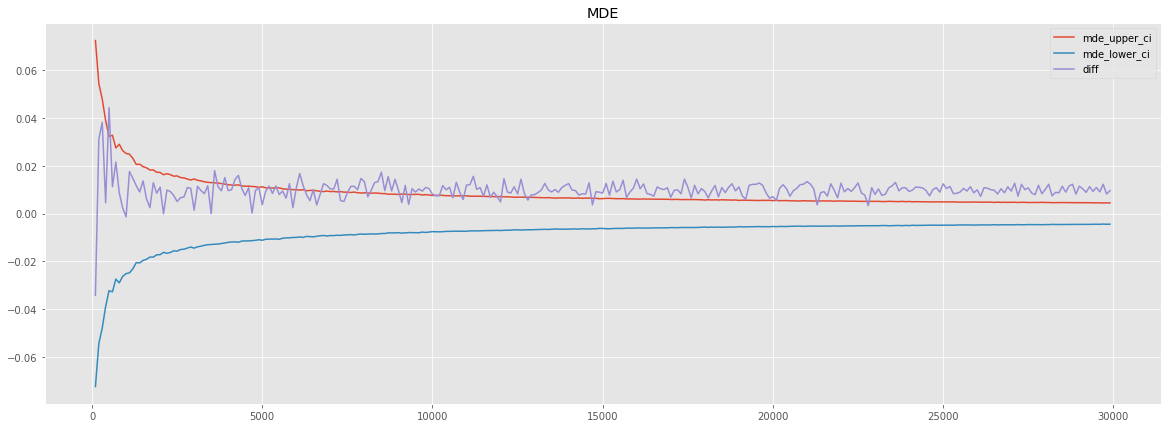

In [9]:
mde_df = pd.DataFrame()
for i in np.arange(100,30000,100):
    tmp_data = pd.concat(generate_data(success_rate=.1,uplift=.1,N=i,is_ctr=True),axis=1)
    mde_df.loc[i,'mde_upper_ci'] = get_ab_size(population=tmp_data.shape[0],std=tmp_data.std().mean())
    mde_df.loc[i,'mde_lower_ci'] = get_ab_size(population=tmp_data.shape[0],std=tmp_data.std().mean()) * -1
    mde_df.loc[i,'diff'] = tmp_data.mean().diff()[1]
# Наглядное схождение MDE
mde_df.plot(title='MDE',figsize=(20,7))

# Metrics test

In [10]:
# Что мы можем найти
get_ab_size(mde = AB_test_params['success_rate'] * AB_test_params['uplift'],
            std=tmp_abc.std(),
            beta=0.2,
            alpha=0.05)

5776.936261187007

In [11]:
check_df = pd.DataFrame()

for n_exp in tqdm(range(2000)):
    
    AA_ = generate_tests(*generate_data(**AA_test_params)).loc['ttest']
    AB_ = generate_tests(*generate_data(**AB_test_params)).loc['ttest']

    tmp_df = pd.DataFrame({'False Positive':AA_,
                            'Power': AB_})

    check_df = pd.concat([check_df,
                            tmp_df])

100%|██████████| 2000/2000 [30:30<00:00,  1.09it/s]


In [12]:
check_df.apply(lambda x: x<0.05).groupby(level=0).mean()

,False Positive,Power
Combo,0.0580,0.9540
ML,0.0440,0.7485
base,0.0440,0.7485
bayesian,0.0365,0.9180
bootstrap,0.0505,0.9365
bucketing,0.0565,0.9340
linearization,0.0505,0.9315
reweight,0.0405,0.8705


In [13]:
def experiment(success_rate=.1,
                uplift=.1,
                N=1000,
                skew=1,
                n_exps = 100,
                beta=100):
                
    result = pd.DataFrame()
    for _ in tqdm(range(n_exps)):
        some_data = generate_data(success_rate=success_rate,
                                    uplift=uplift,
                                    N=N,
                                    skew=skew,
                                    beta=beta)
                                    
        AB_result = generate_tests(*some_data).loc['ttest']
        result = result.append(AB_result.rename(N))
    return result

100%|██████████| 100/100 [00:22<00:00,  4.36it/s]


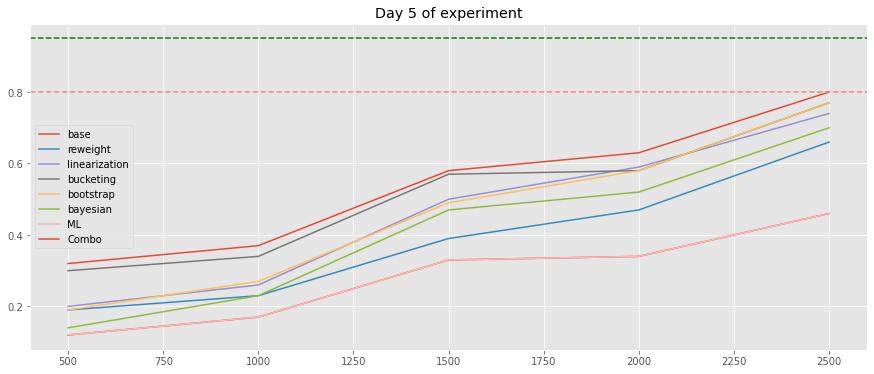

100%|██████████| 100/100 [00:43<00:00,  2.29it/s]


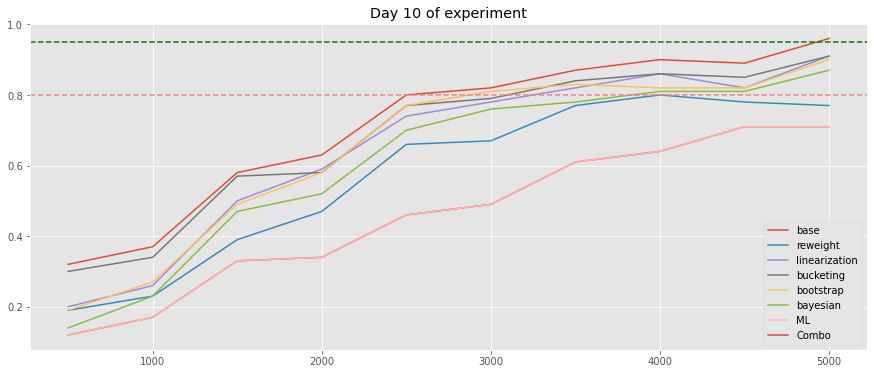

100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


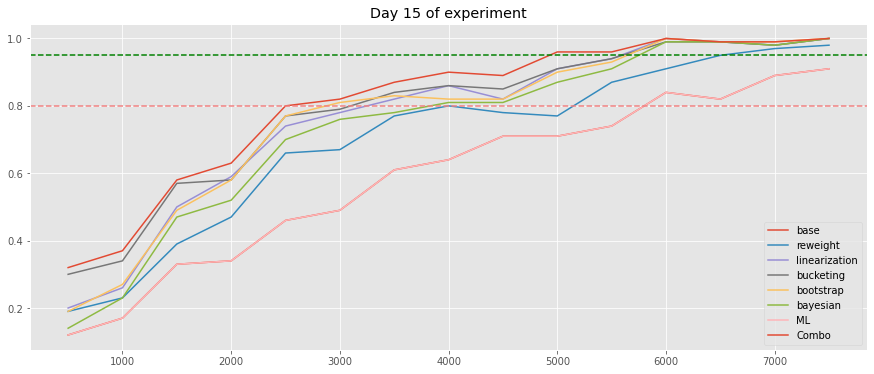

100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


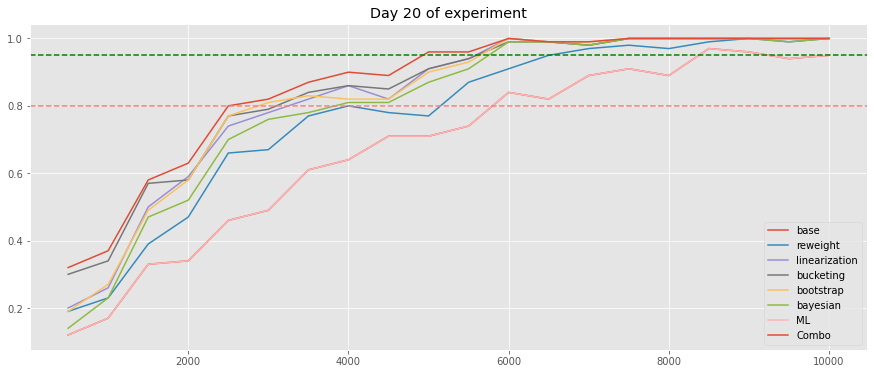

100%|██████████| 100/100 [01:41<00:00,  1.02s/it]


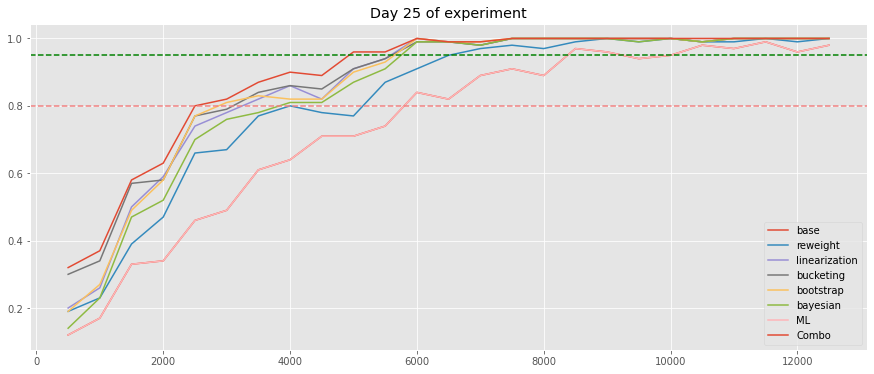

100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


In [14]:
total_syntetic_df = pd.DataFrame()
for day in range(1,30):
    total_syntetic_df = total_syntetic_df.append(experiment(success_rate=0.1,
                                                            uplift=0.1,
                                                            n_exps=100,
                                                            N=500*day))
    if day % 5 ==0:
        total_syntetic_df.apply(lambda x: x<0.05).groupby(level=0).mean().plot(title=f'Day {day} of experiment')
        plt.axhline(0.95,linestyle='--',color='green')
        plt.axhline(0.80,linestyle='--',color='#F08080')
        plt.show()